Shape: (7043, 20)

Dtypes
 gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Head
    gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No  

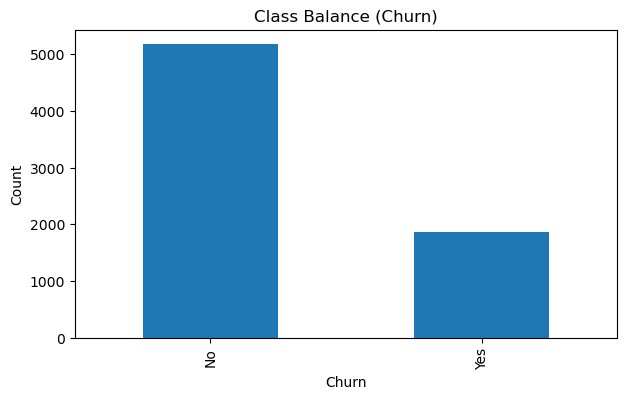

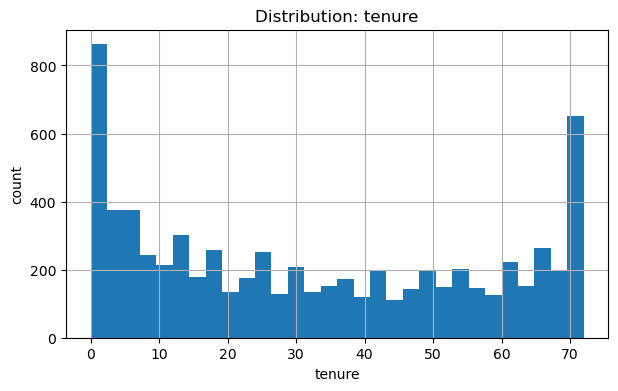

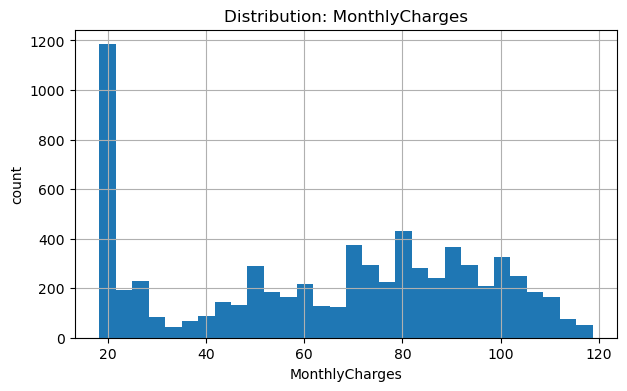

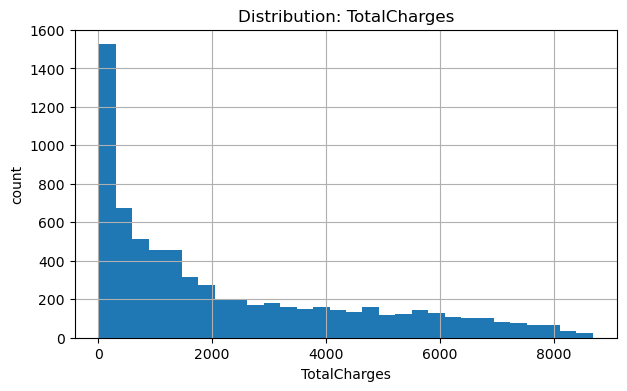

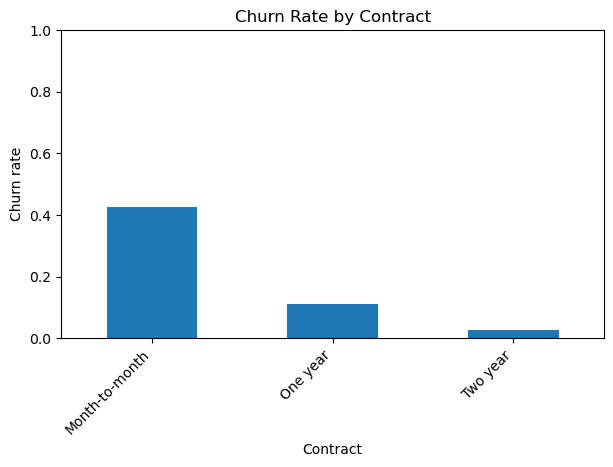

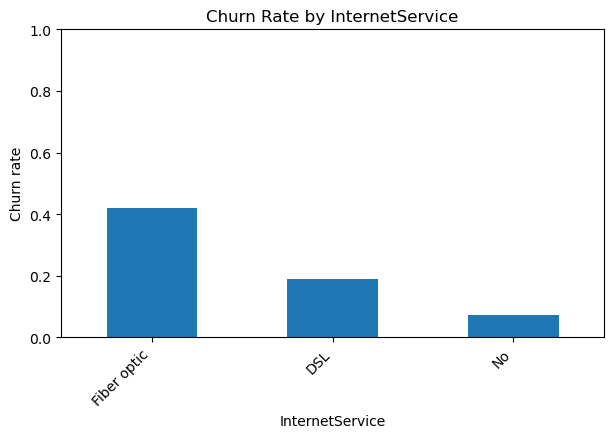

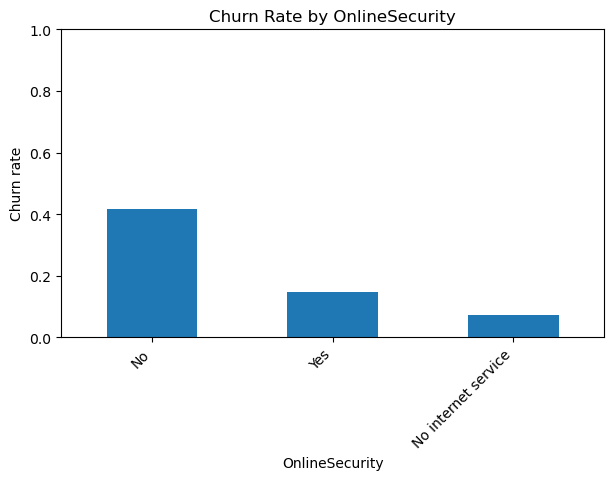

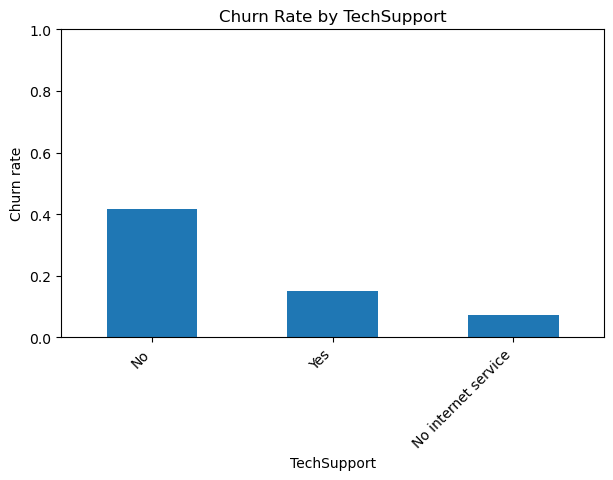

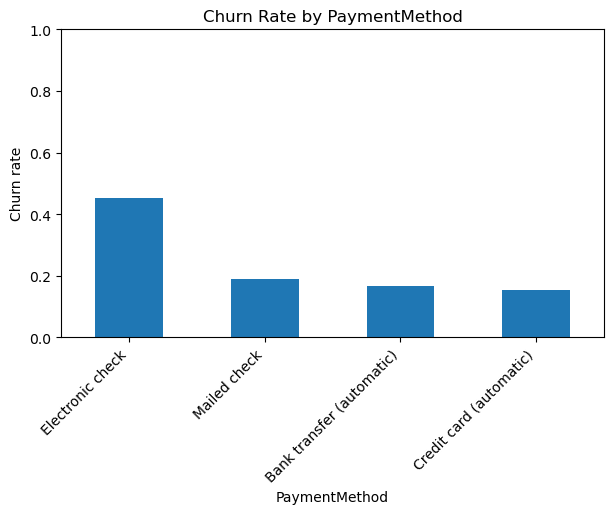


Correlation (numeric features):
 Churn             1.000000
MonthlyCharges    0.193356
SeniorCitizen     0.150889
TotalCharges     -0.199484
tenure           -0.352229
Name: Churn, dtype: float64


In [1]:
# --- Step 1: Load + quick EDA for Telco Churn ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,4)

# 1) Load
df = pd.read_csv("churn.csv")

# 2) Basic cleaning
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# target to 0/1 for quick stats/plots
df["Churn"] = df["Churn"].map({"No":0, "Yes":1})

# TotalCharges sometimes has blanks -> coerce to numeric
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 3) Quick overview
print("Shape:", df.shape)
print("\nDtypes\n", df.dtypes)
print("\nHead\n", df.head(3))

# 4) Class balance
churn_rate = df["Churn"].mean()
print(f"\nChurn rate: {churn_rate:.3f}")

ax = df["Churn"].value_counts().sort_index().rename({0:"No",1:"Yes"}).plot(kind="bar")
ax.set_title("Class Balance (Churn)")
ax.set_ylabel("Count")
plt.show()

# 5) Numeric distributions
num_cols = df.select_dtypes(include=["number"]).columns.drop("Churn")
for col in ["tenure","MonthlyCharges","TotalCharges"]:
    if col in num_cols:
        ax = df[col].hist(bins=30)
        ax.set_title(f"Distribution: {col}")
        ax.set_xlabel(col); ax.set_ylabel("count")
        plt.show()

# 6) Churn rates by key categories
def plot_rate(col):
    if col in df.columns:
        rate = df.groupby(col)["Churn"].mean().sort_values(ascending=False)
        rate.plot(kind="bar")
        plt.title(f"Churn Rate by {col}"); plt.ylabel("Churn rate")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0,1)
        plt.show()

for c in ["Contract","InternetService","OnlineSecurity","TechSupport","PaymentMethod"]:
    plot_rate(c)

# 7) Correlation (numeric↔target)
if len(num_cols) > 0:
    corr = df[num_cols.tolist() + ["Churn"]].corr()
    print("\nCorrelation (numeric features):\n", corr["Churn"].sort_values(ascending=False))


In [5]:
# --- Step 2: Stratified split + preprocessing pipelines (NO MODELS YET) ---
# Robust to scikit-learn version (handles sparse_output vs sparse)

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_sample_weight

# Safety: require Step 1's df
assert "df" in globals(), "Run Step 1 first to create df!"
assert "Churn" in df.columns, "Target 'Churn' missing in df."

# 1) X/y ----------------------------------------------------------------------
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# 2) Column type detection ----------------------------------------------------
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Helper: OHE compatible with all sklearn versions
def make_ohe():
    try:
        # Newer sklearn (>=1.2): uses sparse_output
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        # Older sklearn: uses sparse
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

# 3) Stratified split 70/15/15 ------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# 4) Preprocessing pipelines --------------------------------------------------
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True))   # scaling helps MLP training
])

cat_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())                          # handles unseen categories
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop"
)

# 5) Fit on TRAIN only to avoid leakage --------------------------------------
preprocessor.fit(X_train)

# 6) Transform splits ---------------------------------------------------------
X_train_prep = preprocessor.transform(X_train)
X_val_prep   = preprocessor.transform(X_val)
X_test_prep  = preprocessor.transform(X_test)

# 7) Weights for imbalance (for MLP .fit(sample_weight=...)) ------------------
sample_weight_train = compute_sample_weight(class_weight="balanced", y=y_train)

# 8) Quick sanity prints ------------------------------------------------------
print("Numeric cols:", len(num_cols), "| Categorical cols:", len(cat_cols))
print("Train/Val/Test shapes:", X_train_prep.shape, X_val_prep.shape, X_test_prep.shape)
print("Positives in train/val/test:", y_train.sum(), y_val.sum(), y_test.sum())


Numeric cols: 4 | Categorical cols: 15
Train/Val/Test shapes: (4930, 45) (1056, 45) (1057, 45)
Positives in train/val/test: 1308 280 281



=== RandomForest — Validation Metrics ===
Accuracy : 0.7746
Precision: 0.5905
Recall   : 0.4893
F1-score : 0.5352
ROC-AUC  : 0.8158

Classification report:
              precision    recall  f1-score   support

           0     0.8265    0.8776    0.8512       776
           1     0.5905    0.4893    0.5352       280

    accuracy                         0.7746      1056
   macro avg     0.7085    0.6834    0.6932      1056
weighted avg     0.7639    0.7746    0.7674      1056



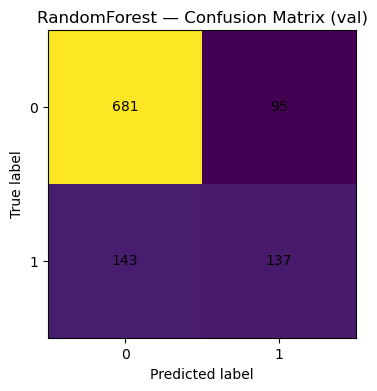

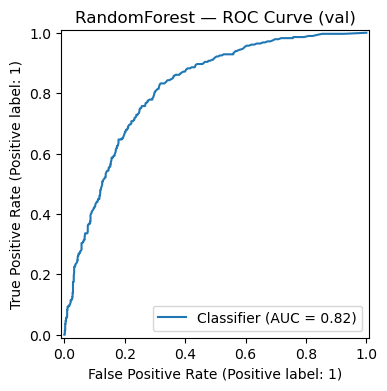


=== MLPClassifier (SMOTE) — Validation Metrics ===
Accuracy : 0.7367
Precision: 0.5026
Recall   : 0.6964
F1-score : 0.5838
ROC-AUC  : 0.8000

Classification report:
              precision    recall  f1-score   support

           0     0.8728    0.7513    0.8075       776
           1     0.5026    0.6964    0.5838       280

    accuracy                         0.7367      1056
   macro avg     0.6877    0.7239    0.6957      1056
weighted avg     0.7746    0.7367    0.7482      1056



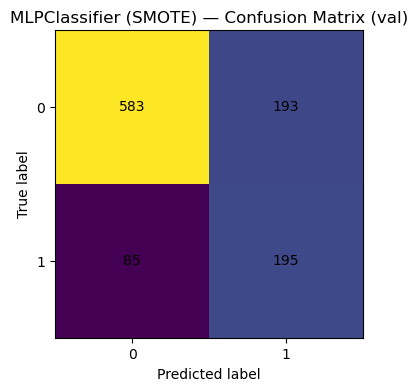

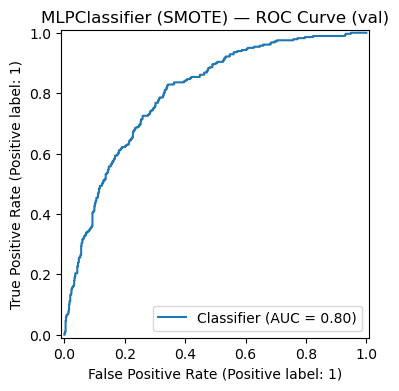


Summary (Validation):
RF : {'accuracy': 0.7746212121212122, 'precision': 0.5905172413793104, 'recall': 0.48928571428571427, 'f1': 0.53515625, 'roc_auc': 0.8157998895434464}
MLP: {'accuracy': 0.7367424242424242, 'precision': 0.5025773195876289, 'recall': 0.6964285714285714, 'f1': 0.5838323353293413, 'roc_auc': 0.7999792893961708}


In [8]:
# --- Step 3 (clean): Baseline models with imbalance handling -----------------
# RF uses class_weight (no parallelism to avoid loky warning on Windows)
# MLP trains on SMOTE-oversampled TRAIN split

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)

# Silence the Windows loky CPU-count warning
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores",
    category=UserWarning,
)

# SMOTE for oversampling (train only)
try:
    from imblearn.over_sampling import SMOTE
except Exception as e:
    raise ImportError("Install imbalanced-learn:\n  !pip install imbalanced-learn") from e

# --------- Safety: need Step 2 objects ---------
for name in ["X_train_prep","y_train","X_val_prep","y_val"]:
    assert name in globals(), f"Missing '{name}'. Run Step 2 first."

# --------- Helpers ---------
def positive_scores(estimator, X):
    """Probability for positive class if available; otherwise decision_function/preds."""
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X).astype(float)
        rng = np.ptp(s)
        return (s - s.min()) / rng if rng > 0 else np.zeros_like(s, dtype=float)
    return estimator.predict(X).astype(float)

def evaluate_on_val(name, model, X_val, y_val):
    y_pred  = model.predict(X_val)
    y_score = positive_scores(model, X_val)

    acc  = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec  = recall_score(y_val, y_pred, zero_division=0)
    f1   = f1_score(y_val, y_pred, zero_division=0)
    auc  = roc_auc_score(y_val, y_score)

    print(f"\n=== {name} — Validation Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}\n")

    print("Classification report:")
    print(classification_report(y_val, y_pred, digits=4))

    # Confusion matrix (pure matplotlib per your environment rules)
    cm = confusion_matrix(y_val, y_pred)
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation="nearest")
    ax.set_title(f"{name} — Confusion Matrix (val)")
    ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()

    RocCurveDisplay.from_predictions(y_val, y_score)
    plt.title(f"{name} — ROC Curve (val)")
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

# --------- 1) Traditional: RandomForest (balanced) ----------
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    class_weight="balanced",
    n_jobs=1,                     # avoid loky parallelism on Windows
)
rf.fit(X_train_prep, y_train)
rf_metrics = evaluate_on_val("RandomForest", rf, X_val_prep, y_val)

# --------- 2) Deep Learning: MLP on SMOTE TRAIN ----------
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_mlp, y_train_mlp = smote.fit_resample(X_train_prep, y_train)

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,
    batch_size="auto",
    max_iter=300,
    early_stopping=True,
    random_state=42,
    verbose=False
)
mlp.fit(X_train_mlp, y_train_mlp)
mlp_metrics = evaluate_on_val("MLPClassifier (SMOTE)", mlp, X_val_prep, y_val)

print("\nSummary (Validation):")
print("RF :", rf_metrics)
print("MLP:", mlp_metrics)


Tuning RandomForest (this uses TRAIN only via CV)...

Best RF params:
{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 200}

RF (tuned) — Validation metrics:
   accuracy: 0.7718
  precision: 0.5520
     recall: 0.7393
         f1: 0.6321
    roc_auc: 0.8402


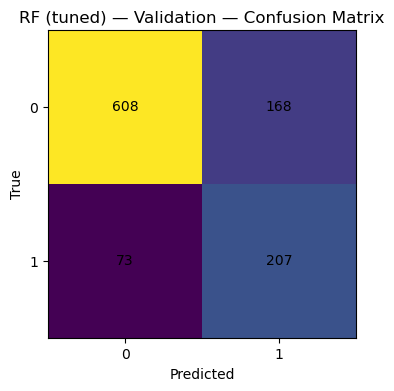

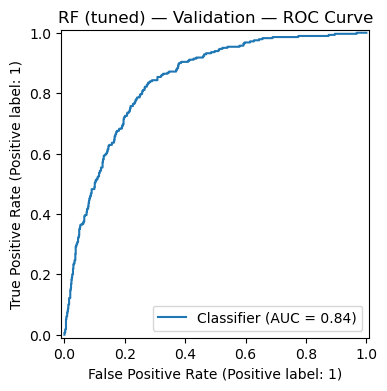


Tuning MLP (on SMOTE-TRAIN, select by VAL ROC-AUC)...
  {'hidden_layer_sizes': (128,), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 128} -> val ROC-AUC = 0.8343
  {'hidden_layer_sizes': (128, 64), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 128} -> val ROC-AUC = 0.7884
  {'hidden_layer_sizes': (256, 128), 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 128} -> val ROC-AUC = 0.7892
  {'hidden_layer_sizes': (128, 64), 'alpha': 0.0003, 'learning_rate_init': 0.0007, 'batch_size': 128} -> val ROC-AUC = 0.7937
  {'hidden_layer_sizes': (128, 64), 'alpha': 0.001, 'learning_rate_init': 0.001, 'batch_size': 256} -> val ROC-AUC = 0.8413

Best MLP config:
{'alpha': 0.001,
 'batch_size': 256,
 'hidden_layer_sizes': (128, 64),
 'learning_rate_init': 0.001}

MLP (tuned, SMOTE) — Validation metrics:
   accuracy: 0.7424
  precision: 0.5089
     recall: 0.8179
         f1: 0.6274
    roc_auc: 0.8413


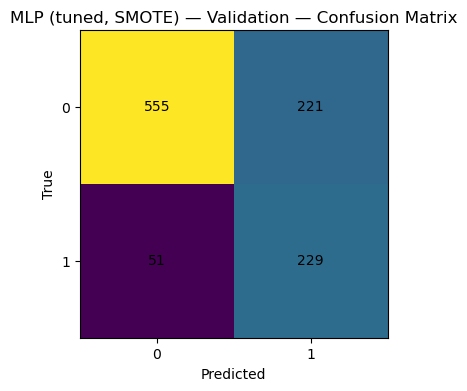

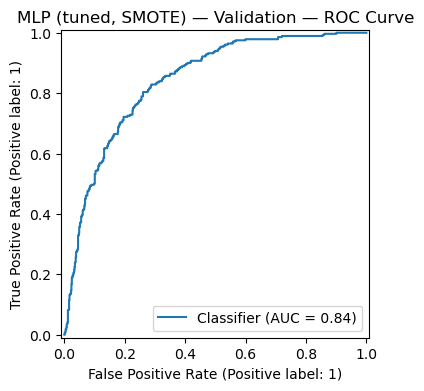


=== Tuning summary (Validation ROC-AUC) ===
RF  tuned AUC: 0.8402
MLP tuned AUC: 0.8413


In [9]:
# --- Step 4: Model tuning (select by Validation ROC-AUC) ----------------------
import warnings
warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores",
    category=UserWarning,
)

import numpy as np
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
rng = np.random.RandomState(42)

# --- Reuse helpers from Step 3 -------------------------------------------------
def positive_scores(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X).astype(float)
        r = np.ptp(s)
        return (s - s.min()) / r if r > 0 else np.zeros_like(s)
    return estimator.predict(X).astype(float)

def eval_metrics(name, model, X, y, plot=False):
    y_pred  = model.predict(X)
    y_score = positive_scores(model, X)
    out = dict(
        accuracy = accuracy_score(y, y_pred),
        precision= precision_score(y, y_pred, zero_division=0),
        recall   = recall_score(y, y_pred, zero_division=0),
        f1       = f1_score(y, y_pred, zero_division=0),
        roc_auc  = roc_auc_score(y, y_score),
    )
    print(f"\n{name} metrics:")
    for k,v in out.items():
        print(f"  {k:>9}: {v:.4f}")
    if plot:
        cm = confusion_matrix(y, y_pred)
        fig, ax = plt.subplots()
        ax.imshow(cm, interpolation="nearest")
        ax.set_title(f"{name} — Confusion Matrix")
        ax.set_xlabel("Predicted"); ax.set_ylabel("True")
        ax.set_xticks([0,1]); ax.set_yticks([0,1])
        for (i, j), v in np.ndenumerate(cm):
            ax.text(j, i, str(v), ha="center", va="center")
        plt.show()
        RocCurveDisplay.from_predictions(y, y_score)
        plt.title(f"{name} — ROC Curve")
        plt.show()
    return out

# Safety (needs Step 2 arrays)
for v in ["X_train_prep","y_train","X_val_prep","y_val"]:
    assert v in globals(), f"Missing {v}; run Step 2."

# ====================== A) Tune RandomForest (traditional) ======================
rf_base = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=1,  # avoid loky warning on Windows
)

rf_param_dist = {
    "n_estimators":   [200, 300, 400, 600, 800, 1000],
    "max_depth":      [None, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 2, 4],
    "max_features":   ["sqrt", "log2", 0.5, None],
}

rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=1,           # keep single-threaded
    verbose=0,
)

print("Tuning RandomForest (this uses TRAIN only via CV)...")
rf_search.fit(X_train_prep, y_train)

print("\nBest RF params:")
pprint(rf_search.best_params_)
rf_best = rf_search.best_estimator_

# Evaluate tuned RF on VALIDATION set
rf_val = eval_metrics("RF (tuned) — Validation", rf_best, X_val_prep, y_val, plot=True)

# ====================== B) Tune MLP (deep learning) ============================
# Oversample TRAIN ONLY (never touch val/test)
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = smote.fit_resample(X_train_prep, y_train)

mlp_grid = [
    {"hidden_layer_sizes": (128,),    "alpha": 1e-4, "learning_rate_init": 1e-3, "batch_size": 128},
    {"hidden_layer_sizes": (128,64),  "alpha": 1e-4, "learning_rate_init": 1e-3, "batch_size": 128},
    {"hidden_layer_sizes": (256,128), "alpha": 1e-4, "learning_rate_init": 1e-3, "batch_size": 128},
    {"hidden_layer_sizes": (128,64),  "alpha": 3e-4, "learning_rate_init": 7e-4, "batch_size": 128},
    {"hidden_layer_sizes": (128,64),  "alpha": 1e-3, "learning_rate_init": 1e-3, "batch_size": 256},
]

best_mlp, best_auc, best_cfg = None, -np.inf, None
print("\nTuning MLP (on SMOTE-TRAIN, select by VAL ROC-AUC)...")
for cfg in mlp_grid:
    mlp = MLPClassifier(
        hidden_layer_sizes=cfg["hidden_layer_sizes"],
        activation="relu",
        solver="adam",
        learning_rate_init=cfg["learning_rate_init"],
        alpha=cfg["alpha"],
        batch_size=cfg["batch_size"],
        max_iter=300,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42,
        verbose=False,
    )
    mlp.fit(X_train_sm, y_train_sm)
    auc = roc_auc_score(y_val, positive_scores(mlp, X_val_prep))
    print(f"  {cfg} -> val ROC-AUC = {auc:.4f}")
    if auc > best_auc:
        best_auc, best_mlp, best_cfg = auc, mlp, cfg

print("\nBest MLP config:")
pprint(best_cfg)

mlp_val = eval_metrics("MLP (tuned, SMOTE) — Validation", best_mlp, X_val_prep, y_val, plot=True)

print("\n=== Tuning summary (Validation ROC-AUC) ===")
print(f"RF  tuned AUC: {rf_val['roc_auc']:.4f}")
print(f"MLP tuned AUC: {mlp_val['roc_auc']:.4f}")


Final shapes — Train+Val: (5986, 45)  | Test: (1057, 45)

=== RandomForest (FINAL) — TEST Metrics ===
Accuracy : 0.7748
Precision: 0.5653
Recall   : 0.6619
F1-score : 0.6098
ROC-AUC  : 0.8405


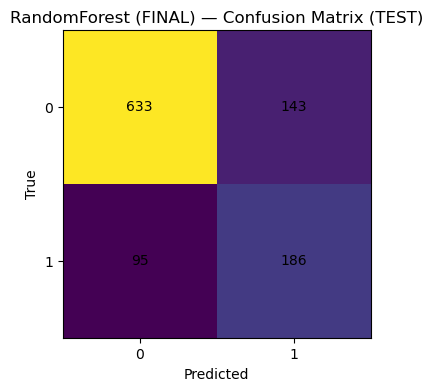

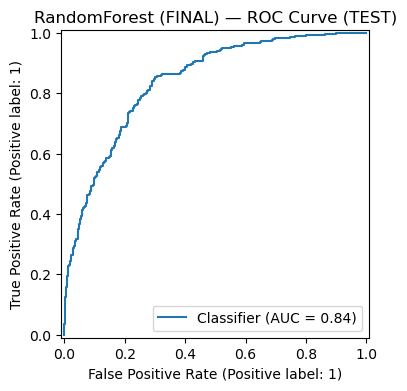


=== MLP (FINAL, SMOTE) — TEST Metrics ===
Accuracy : 0.7663
Precision: 0.5545
Recall   : 0.6157
F1-score : 0.5835
ROC-AUC  : 0.8221


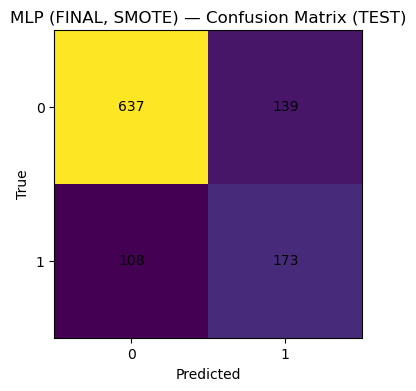

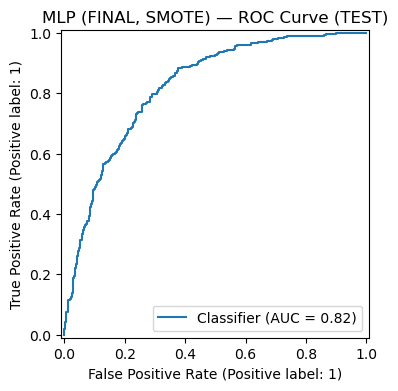


=== FINAL Test Summary ===
RF : {'accuracy': 0.7748344370860927, 'precision': 0.5653495440729484, 'recall': 0.6619217081850534, 'f1': 0.6098360655737705, 'roc_auc': 0.8404767582639322}
MLP: {'accuracy': 0.7663197729422895, 'precision': 0.5544871794871795, 'recall': 0.6156583629893239, 'f1': 0.5834738617200674, 'roc_auc': 0.822123674652383}

Saved models: rf_churn_pipeline.joblib, mlp_churn_pipeline.joblib


In [10]:
# --- Step 5: Final fit on Train+Val and one-time Test evaluation ---------------
import warnings, numpy as np, matplotlib.pyplot as plt, joblib
from pprint import pprint

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay
)
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

warnings.filterwarnings(
    "ignore",
    message="Could not find the number of physical cores",
    category=UserWarning,
)

# ---- Safety: need Step 2 splits and Step 4 best params/configs ----
for v in ["X_train_prep","X_val_prep","X_test_prep","y_train","y_val","y_test","rf_search","best_mlp","best_cfg"]:
    assert v in globals(), f"Missing {v}. Ensure Steps 2–4 have run."

# Helper to get positive scores
def positive_scores(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X).astype(float)
        r = np.ptp(s)
        return (s - s.min()) / r if r > 0 else np.zeros_like(s)
    return estimator.predict(X).astype(float)

def evaluate_on_test(name, model, X_test, y_test):
    y_pred  = model.predict(X_test)
    y_score = positive_scores(model, X_test)

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    auc  = roc_auc_score(y_test, y_score)

    print(f"\n=== {name} — TEST Metrics ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots()
    ax.imshow(cm, interpolation="nearest")
    ax.set_title(f"{name} — Confusion Matrix (TEST)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_score)
    plt.title(f"{name} — ROC Curve (TEST)")
    plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

# -------------------- Refit PREPROCESSOR on Train+Val --------------------------
# Recreate raw X splits from df (we recompute to refit the preprocessor cleanly)
X = df.drop(columns=["Churn"])
y = df["Churn"].astype(int)

# Recover the original column lists (from Step 2)
num_cols = X.select_dtypes(include=np.number).columns.tolist()
cat_cols = X.select_dtypes(exclude=np.number).columns.tolist()

# Compatibility helper for OneHotEncoder
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler(with_mean=True))
])
categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", make_ohe())
])
preprocessor_final = ColumnTransformer(
    transformers=[("num", numeric_pipe, num_cols),
                  ("cat", categorical_pipe, cat_cols)],
    remainder="drop"
)

# Build Train+Val indices manually (same rows we used before)
# We can reconstruct by concatenating the already-preprocessed arrays’ row counts,
# but simpler & exact: combine the X_train and X_val from Step 2 (still available).
# If you didn't keep the raw X_train/X_val, we can slice by length against df.
# Here, we refit using the *actual rows* used in those splits via boolean masks.

# Recreate raw splits from the indices of the preprocessed arrays lengths:
# (We can't perfectly reconstruct indices from arrays alone; so instead we
#   re-split deterministically with the same random_state and stratify.)
from sklearn.model_selection import train_test_split
X_all = X
y_all = y

X_train_raw, X_temp_raw, y_train_raw, y_temp_raw = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all
)
X_val_raw, X_test_raw, y_val_raw, y_test_raw = train_test_split(
    X_temp_raw, y_temp_raw, test_size=0.50, random_state=42, stratify=y_temp_raw
)

# Combine Train+Val raw:
X_trval_raw = pd.concat([X_train_raw, X_val_raw], axis=0)
y_trval_raw = pd.concat([y_train_raw, y_val_raw], axis=0)

# Fit preprocessor on Train+Val
preprocessor_final.fit(X_trval_raw)

# Transform Train+Val and Test
X_trval = preprocessor_final.transform(X_trval_raw)
X_test_final = preprocessor_final.transform(X_test_raw)
y_trval = y_trval_raw.values
y_test_final = y_test_raw.values

print("Final shapes — Train+Val:", X_trval.shape, " | Test:", X_test_final.shape)

# -------------------- Refit tuned RandomForest on Train+Val --------------------
rf_params = rf_search.best_params_.copy()
rf_params.update(dict(class_weight="balanced", random_state=42, n_jobs=1))
rf_final = RandomForestClassifier(**rf_params)
rf_final.fit(X_trval, y_trval)

rf_test = evaluate_on_test("RandomForest (FINAL)", rf_final, X_test_final, y_test_final)

# -------------------- Refit tuned MLP on SMOTE(Train+Val) ---------------------
smote = SMOTE(random_state=42, k_neighbors=5)
X_trval_sm, y_trval_sm = smote.fit_resample(X_trval, y_trval)

mlp_final = MLPClassifier(
    hidden_layer_sizes=best_cfg["hidden_layer_sizes"],
    activation="relu",
    solver="adam",
    learning_rate_init=best_cfg["learning_rate_init"],
    alpha=best_cfg["alpha"],
    batch_size=best_cfg["batch_size"],
    max_iter=300,
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42,
    verbose=False
)
mlp_final.fit(X_trval_sm, y_trval_sm)

mlp_test = evaluate_on_test("MLP (FINAL, SMOTE)", mlp_final, X_test_final, y_test_final)

print("\n=== FINAL Test Summary ===")
print("RF :", rf_test)
print("MLP:", mlp_test)

# -------------------- (Optional) Save deployable pipelines --------------------
from sklearn.pipeline import Pipeline as SkPipeline
rf_pipeline = SkPipeline([("preprocess", preprocessor_final), ("model", rf_final)])
mlp_pipeline = SkPipeline([("preprocess", preprocessor_final), ("model", mlp_final)])

joblib.dump(rf_pipeline, "rf_churn_pipeline.joblib")
joblib.dump(mlp_pipeline, "mlp_churn_pipeline.joblib")
print("\nSaved models: rf_churn_pipeline.joblib, mlp_churn_pipeline.joblib")


In [11]:
# --- 6A: Resolve engineered feature names from preprocessor_final -------------
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def get_feature_names(preprocessor, num_cols, cat_cols):
    """
    Returns list[str] of transformed feature names in the same order as transform().
    Works for OneHotEncoder in both old/new sklearn.
    """
    names = []
    # numeric pipeline -> keeps original numeric names (after impute+scale)
    names.extend(num_cols)

    # categorical pipeline -> expand OHE names
    ohe = preprocessor.named_transformers_["cat"].named_steps["ohe"]
    cat_out = []
    if hasattr(ohe, "get_feature_names_out"):
        cat_out = ohe.get_feature_names_out(cat_cols).tolist()
    else:
        # older API
        cat_out = ohe.get_feature_names(cat_cols).tolist()
    names.extend(cat_out)
    return names

feat_names = get_feature_names(preprocessor_final, num_cols, cat_cols)
len(feat_names), feat_names[:10]


(45,
 ['SeniorCitizen',
  'tenure',
  'MonthlyCharges',
  'TotalCharges',
  'gender_Female',
  'gender_Male',
  'Partner_No',
  'Partner_Yes',
  'Dependents_No',
  'Dependents_Yes'])

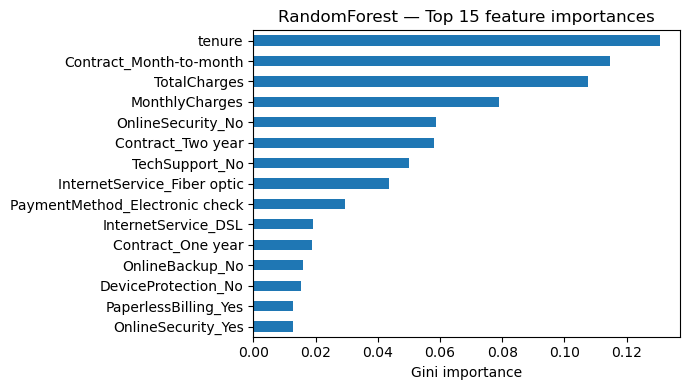

Top features:
 tenure                                 0.130637
Contract_Month-to-month                0.114603
TotalCharges                           0.107506
MonthlyCharges                         0.078833
OnlineSecurity_No                      0.058720
Contract_Two year                      0.058006
TechSupport_No                         0.050173
InternetService_Fiber optic            0.043601
PaymentMethod_Electronic check         0.029368
InternetService_DSL                    0.019176
Contract_One year                      0.018889
OnlineBackup_No                        0.015992
DeviceProtection_No                    0.015419
PaperlessBilling_Yes                   0.012906
OnlineSecurity_Yes                     0.012621
StreamingMovies_No internet service    0.012438
TechSupport_Yes                        0.012055
PaperlessBilling_No                    0.010791
gender_Male                            0.010780
gender_Female                          0.009673
dtype: float64


In [12]:
# --- 6B: RF tree-based importances -------------------------------------------
import matplotlib.pyplot as plt

rf_imp = pd.Series(rf_final.feature_importances_, index=feat_names).sort_values(ascending=False)
topk = 15
ax = rf_imp.head(topk).iloc[::-1].plot(kind="barh")
ax.set_title(f"RandomForest — Top {topk} feature importances")
ax.set_xlabel("Gini importance")
plt.tight_layout(); plt.show()

print("Top features:\n", rf_imp.head(20))


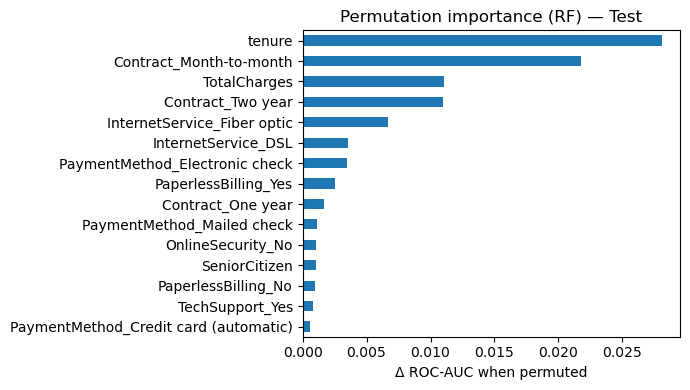

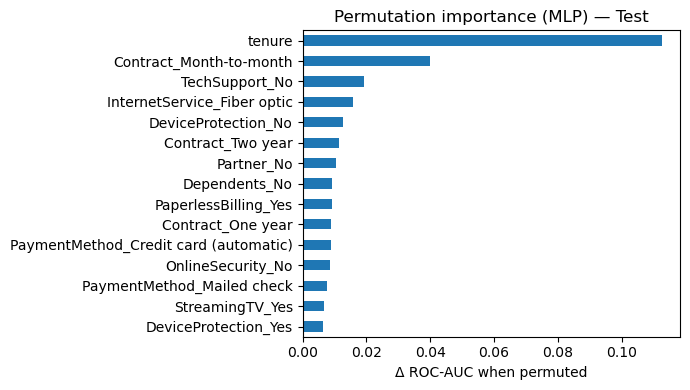

RF perm top 10:
 tenure                            0.028098
Contract_Month-to-month           0.021730
TotalCharges                      0.011033
Contract_Two year                 0.010989
InternetService_Fiber optic       0.006655
InternetService_DSL               0.003535
PaymentMethod_Electronic check    0.003441
PaperlessBilling_Yes              0.002504
Contract_One year                 0.001691
PaymentMethod_Mailed check        0.001104
dtype: float64

MLP perm top 10:
 tenure                         0.112630
Contract_Month-to-month        0.040015
TechSupport_No                 0.019285
InternetService_Fiber optic    0.015886
DeviceProtection_No            0.012523
Contract_Two year              0.011495
Partner_No                     0.010551
Dependents_No                  0.009279
PaperlessBilling_Yes           0.009076
Contract_One year              0.008933
dtype: float64


In [13]:
# --- 6C: Permutation importance (TEST) ---------------------------------------
from sklearn.inspection import permutation_importance

def permutation_rank(model, X, y, names, n_repeats=10, random_state=42):
    r = permutation_importance(model, X, y, n_repeats=n_repeats,
                               random_state=random_state, n_jobs=1, scoring="roc_auc")
    imp = pd.Series(r.importances_mean, index=names).sort_values(ascending=False)
    return imp, r

rf_perm, _   = permutation_rank(rf_final,  X_test_final, y_test_final, feat_names)
mlp_perm, _  = permutation_rank(mlp_final, X_test_final, y_test_final, feat_names)

ax = rf_perm.head(15).iloc[::-1].plot(kind="barh")
ax.set_title("Permutation importance (RF) — Test")
ax.set_xlabel("Δ ROC-AUC when permuted")
plt.tight_layout(); plt.show()

ax = mlp_perm.head(15).iloc[::-1].plot(kind="barh")
ax.set_title("Permutation importance (MLP) — Test")
ax.set_xlabel("Δ ROC-AUC when permuted")
plt.tight_layout(); plt.show()

print("RF perm top 10:\n", rf_perm.head(10))
print("\nMLP perm top 10:\n", mlp_perm.head(10))


<Figure size 600x400 with 0 Axes>

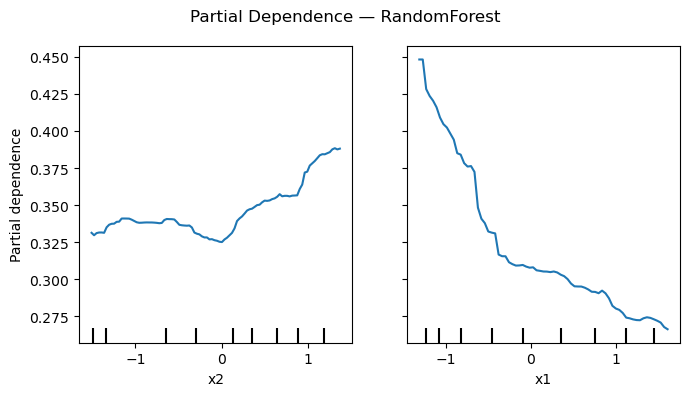

<Figure size 600x400 with 0 Axes>

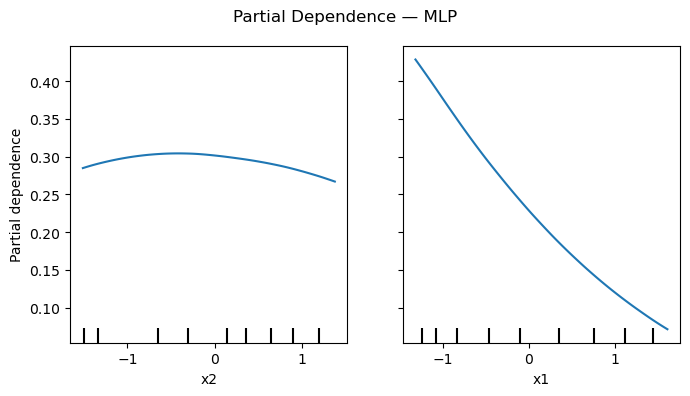

In [14]:
# --- 6D: Partial Dependence on key numeric features --------------------------
from sklearn.inspection import PartialDependenceDisplay

# choose two numeric drivers commonly important in churn
num_targets = [c for c in ["MonthlyCharges", "tenure"] if c in num_cols]

if num_targets:
    # get their indices in transformed space (numeric block is first and preserves order)
    idxs = [num_cols.index(c) for c in num_targets]

    # PDP for RF
    fig = plt.figure(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        rf_final, X_test_final, features=idxs, kind="average"
    )
    plt.suptitle("Partial Dependence — RandomForest"); plt.tight_layout(); plt.show()

    # PDP for MLP
    fig = plt.figure(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(
        mlp_final, X_test_final, features=idxs, kind="average"
    )
    plt.suptitle("Partial Dependence — MLP"); plt.tight_layout(); plt.show()
else:
    print("No numeric targets available for PDP.")
